# Quadrant<->CCD<->FocalPlane


The ZTF camera has three levels of data:
1. the `focal plane`, made of 16 `CCD`s
2. the `CCD`s that are made of 4 read-out channel, called `quadrant`s
3. the `quadrant`s.

***
## Concept

### ztfimg objects and their connections

The data and header access is made at the `Quadrant` level. A `CCD` object is a collection of `quadrant`s, while the `FocalPlane`is a collection of `CCD`s. 

Under usual `ztfquery` file structure environment, it is easy to retrieve the filepath of various elements of the CCD or focal plane given a quadrant filename. For instance, given any quadrant filename, the `from_single_filename()` method of `CCD` and `FocalPlane` uses `ztfquery` to access the 3 missing quadrants to form a `CCD` or the 63 ones to form the `FocalPlane`.

Conversely, since `CCD` is a collection of `Quadrant`, their `.quadrants` attribute is a dictionary of `Quadrant` and the `get_quadrant(qid)` method provides an easy access to any of them. Similarly, `FocalPlane` have a `.ccds` attribute and `get_ccd(ccdid)` and `get_quadrant(rcid)` methods enable to access a given `CCD` or `Quadrant` object. **Careful**, the CCD method `get_quadrant(qid)` expects a qid (1->4) while the FocalPlane `get_quadrant(rcid)` methods expects a rcid (0->63).

To conserve the symmetry, a `Quadrant` object has a `get_ccd()` method that calls `CCD.from_single_filename()` using it's own filename and a `get_focalplane` that does the same for `FocalPlane` ; a `CCD` also has a `get_focalplane` doing the same using its first quadrant's filename.

### Base, Raw and Science

The aforementioned connections between `Quadrant`, `CCD` and `FocalPlane` hold for any kind of Images (Base, Raw or Science). A `ScienceQuadrant` will build a `ScienceCCD` and `ScienceFocalPlane` when calling `get_ccd()` or `get_focalplane()` and so on. 

### Careful with memory
A `FocalPlane` is made of 64 quadrants and  `ScienceQuadrant` are made of image + mask data. So loading a `FocalPlane` can blow up your RAM. It is thus suggested to use dask when working with `FocalPlane`s and make sure not to compute too large data on a single memory node ; `data` from FocalPlane ~5GB.

***
##  ScienceQuadrant -> ScienceCCD -> ScienceFocalPlane

In [1]:
import ztfimg
qimg = ztfimg.ScienceQuadrant.from_filename("ztf_20200924431759_000655_zr_c13_o_q3_sciimg.fits",
                                   as_path=False)

In [2]:
qimg.filename

'/Users/rigault/data/ztf/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c13_o_q3_sciimg.fits'

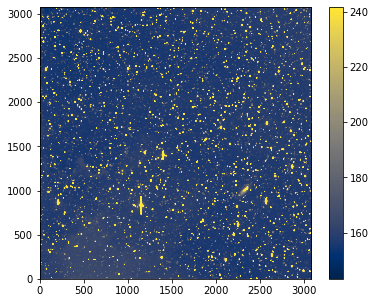

In [3]:
_ = qimg.show()

### Now let's get its CCD.

you have two ways:
1. The manual version using `from_single_filename`

In [4]:
# use as_path=False to make sure it download the missing data
ccd = ztfimg.ScienceCCD.from_single_filename(qimg.filename, as_path=False)

2. The shortcut `get_ccd()` method. (it does the manual version for you)

In [5]:
ccd = qimg.get_ccd()

let's have a look

In [6]:
ccd.get_data()

array([[ 44.91321  , 167.88715  , 206.81393  , ..., 174.49977  ,
        135.91026  ,  48.02796  ],
       [ 16.670918 ,  78.78005  , 138.10672  , ..., 152.18134  ,
        103.460335 ,  18.992094 ],
       [ 17.609827 ,  87.123825 , 152.8368   , ..., 166.77153  ,
        105.01655  ,  25.638815 ],
       ...,
       [  4.8058763,  49.65675  ,  99.17695  , ..., 149.64104  ,
         96.56672  ,  16.636278 ],
       [  8.345967 ,  48.599697 ,  96.20216  , ..., 151.22047  ,
        100.14231  ,  20.201305 ],
       [  8.68024  ,  56.990013 , 116.7488   , ..., 162.11705  ,
        126.70934  ,  30.59527  ]], dtype=float32)

In [7]:
ccd.filenames

['/Users/rigault/data/ztf/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c13_o_q1_sciimg.fits',
 '/Users/rigault/data/ztf/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c13_o_q2_sciimg.fits',
 '/Users/rigault/data/ztf/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c13_o_q3_sciimg.fits',
 '/Users/rigault/data/ztf/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c13_o_q4_sciimg.fits']

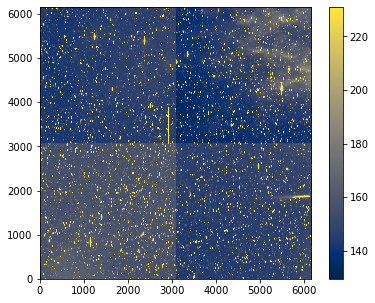

In [8]:
_ = ccd.show()

In [9]:
ccd.quadrants

{1: <ztfimg.science.ScienceQuadrant at 0x104b14fd0>,
 2: <ztfimg.science.ScienceQuadrant at 0x287c2be20>,
 3: <ztfimg.science.ScienceQuadrant at 0x287c71970>,
 4: <ztfimg.science.ScienceQuadrant at 0x287c64ca0>}

### Now let's get the FocalPlane

We will use dask to manage the RAM. 

In [12]:
import dask
from dask.distributed import Client
client = Client()

As for quadrant->ccd, the manual FocalPlane. and the shortcut get_focalplane() method like for CCDs.

In [13]:
# you could have used qimg.get_focalplane(use_dask=True), it is strictly equivalent
fp = ccd.get_focalplane(use_dask=True) 

In [14]:
fp.filenames

[Delayed('get_file-0168f419-53dd-4c2e-ae31-022dbfd92e11'),
 Delayed('get_file-5d2c4d1b-1062-4420-b49c-cfb44897d8b9'),
 Delayed('get_file-d707c73d-de1d-4357-8d0b-f3f25f1d7199'),
 Delayed('get_file-81e4573e-e8bd-4152-ae02-e13a095c3257'),
 Delayed('get_file-6885dc9f-59f6-43b9-8d60-ef2b9bfa3b1a'),
 Delayed('get_file-1497d3d7-9e64-4f37-9ee6-742dd7e2884f'),
 Delayed('get_file-17b18d85-621f-43a5-9465-d50f8bd93ae5'),
 Delayed('get_file-5f9e7214-3621-4cdb-ae92-55970de45946'),
 Delayed('get_file-465d7378-ec81-4647-a954-7e83230acad4'),
 Delayed('get_file-f939f449-6af6-432d-832c-b1c0e738bc41'),
 Delayed('get_file-ab2f8ba1-8a24-431e-a8ad-09a2eb6f17e0'),
 Delayed('get_file-a8ff66f6-0230-4058-9ef5-14f0beee64a5'),
 Delayed('get_file-28398504-b6f5-4569-b294-14efea04754f'),
 Delayed('get_file-a8f72d9b-2fec-4a0b-9992-4e7859023bb9'),
 Delayed('get_file-2efa89f4-0d0f-4bc0-aaa2-99f797906c6f'),
 Delayed('get_file-130aa79a-5bea-4b66-bb79-ecdfa3af6a1c'),
 Delayed('get_file-34541972-93b5-4ebc-a3f1-425007fdde0a'

In [15]:
fp.get_data()

dask.array<concatenate, shape=(26656, 26040), dtype=float64, chunksize=(3080, 3072), chunktype=numpy.ndarray>

**tip**: the rebin methods bins and average the pixels X by X. It fastens a lot the plotting (and reduce the local RAM usage) for quick look. X must be a multiple of the array shape, so 2,4,8,16 works well

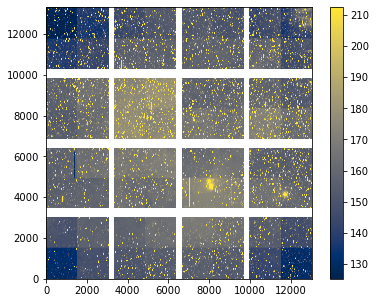

In [16]:
_ = fp.show(rebin=2) # check you localhost:8787

## In the other direction

Let's get the quadrant 1 of the CCD.

In [17]:
q1 = ccd.get_quadrant(1)

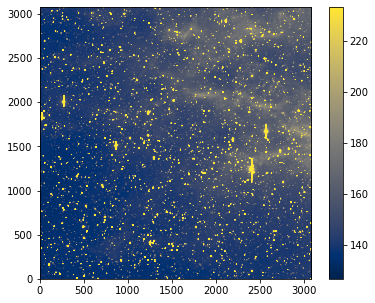

In [18]:
_ = q1.show()

The CCD 11 from the FocalPlane

In [19]:
ccd11 = fp.get_ccd(11)

Remark that, since fp is dasked, ccd11 will also be.

In [20]:
ccd11.get_data()

dask.array<concatenate, shape=(6160, 6144), dtype=float32, chunksize=(3080, 3072), chunktype=numpy.ndarray>

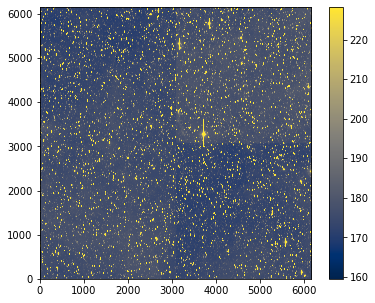

In [21]:
_ = ccd11.show()

Or any quadrant from the FocalPlane (rcid)

In [22]:
q35 = fp.get_quadrant(35)

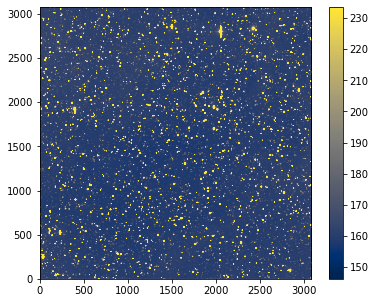

In [23]:
_ = q35.show()

***
## ZTF Camera structure

the `ztffields` package (https://ztffields.readthedocs.io/) enables you to quickly see the structure of the ztfcamera

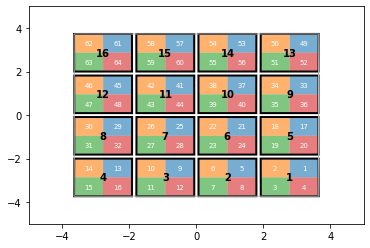

In [24]:
import ztffields
_ = ztffields.show_ztf_footprint()

Blod numbers are `ccdid`, white number are `rcid` and colors are `qid` (0:blue, 1:orange, 2:green, 3:red)